<a href="https://colab.research.google.com/github/WahomeKennedy/ML-Projects/blob/main/Face_recognition_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 4.9 MB/s 


In [ ]:
%tensorflow_version 2.x 

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, datasets
import matplotlib.pyplot as plt
import numpy as np
import mtcnn
from mtcnn.mtcnn import MTCNN
import PIL
import os
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#This function extracts features of faces of images
def extract_face(filename, image_pixels = None, image_size=(160,160)):
  if filename is not None:
    image = PIL.Image.open(filename)
    detector = MTCNN()
    image = image.convert('RGB')
    pixels = np.asarray(image)
  elif image_pixels is not None:
    pixels = image_pixels
  results = detector.detect_faces(pixels)
  x1, y1, w, h = results[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = (x1+w), (y1+h)
  face = pixels[y1:y2, x1:x2]
  box = (x1, y1, w, h)
  image = PIL.Image.fromarray(face)
  image = image.resize(image_size)
  face_array = np.asarray(image)
  return face_array

In [ ]:
# specify folder to plot
folder = '/content/gdrive/MyDrive/Faces/Train/Roy/'
i = 1
# enumerate files
from os import listdir
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	plt.subplot(2, 7, i)
	plt.axis('off')
	plt.imshow(face)
	i += 1
plt.show()

FileNotFoundError: ignored

In [ ]:
def load_faces(directory):
  faces = list()
  for filename in os.listdir(directory):
   path = directory + filename
   face = extract_face(path)
   faces.append(face)
  return faces

In [ ]:
def load_dataset(directory):
  i=1
  x,y = list(), list()
  for subdir in os.listdir(directory):
    path = directory + subdir + '/'
    if not os.path.isdir(path):
      continue
    faces = load_faces(path)
    labels = [subdir for _ in range(len(faces))]
    print('%d loaded %d examples for class: %s' %(i,len(faces), subdir))
    x.extend(faces)
    y.extend(labels)
    i+=1
  return np.asarray(x), np.asarray(y)
    

Only uncomment and run these cells when you have added new photos in the dataset.


In [ ]:
# trainx, trainy = load_dataset('/content/gdrive/MyDrive/Faces/Train/')
# print(trainx.shape, trainy.shape)



In [ ]:
# valx, valy =load_dataset('/content/gdrive/MyDrive/Faces/Validate/')
# print(valx.shape, valy.shape)

In [ ]:
# np.savez_compressed('/content/gdrive/MyDrive/Faces/face extaction.npz', trainx, trainy, valx, valy)

Load only the current extracted faces file in the drive to avoid confusion.


In [ ]:
#loading face data
data1 = np.load('/content/gdrive/MyDrive/Faces/face extraction.npz')
trainx, trainy, valx, valy = data1['arr_0'], data1['arr_1'], data1['arr_2'], data1['arr_3']
print('loaded features and labels: ',trainx.shape, trainy.shape, valx.shape, valy.shape)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
#loading in the facenet model:
model = load_model('/content/gdrive/MyDrive/Faces/model/facenet_keras.h5')
print('Loaded model')

In [ ]:
def get_embedding(model, face_pixels):
  face_pixels = face_pixels.astype('float32')
  mean, std = face_pixels.mean(), face_pixels.std()
  face_pixels = (face_pixels - mean)/std
  samples = np.expand_dims(face_pixels, axis=0)
  predictions = model.predict(samples)
  return predictions[0]


Uncomment and run cells only if there are new files added to the drive.




In [ ]:
#convert faces in train to an embedding

# NtrainX = list()
# for face_pixels in trainx:
# 	embedding = get_embedding(model, face_pixels)
# 	NtrainX.append(embedding)
 
# NtrainX = np.asarray(NtrainX)
# print(NtrainX.shape)

In [ ]:
#convert faces in validate to an embedding

# Nvalx = list()
# for face_pixels in valx:
#   embedding = get_embedding(model, face_pixels)
#   Nvalx.append(embedding)

# Nvalx = np.asarray(Nvalx)
# print(Nvalx.shape)

In [ ]:
# np.savez_compressed('/content/gdrive/MyDrive/Faces/Face embeddings.npz', NtrainX, trainy, Nvalx, valy)

Load the current face embedding in the drive to avoid confusion



In [ ]:
#load face embeddings
embed_data = np.load('/content/gdrive/MyDrive/Faces/Face embeddings.npz')
#classification of faces
trainX, trainy, valX, valy = embed_data['arr_0'], embed_data['arr_1'], embed_data['arr_2'], embed_data['arr_3']

In [ ]:
print('loaded dataset: train= %d, val=%d' % (trainX.shape[0], valx.shape[0]))
print('loaded labels: train_labels = %d, val_labels = %d' % (trainy.shape[0], valy.shape[0]))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

In [ ]:
import pickle

In [ ]:
#normalization of vectors
in_encoder = Normalizer(norm='l2')
trainX= in_encoder.transform(trainX)
valX = in_encoder.transform(valX)

In [ ]:
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
valy = out_encoder.transform(valy)


In [ ]:
np.savez_compressed('/content/gdrive/MyDrive/Faces/out_encoder.npz',out_encoder,trainX, trainy, valX, valy)

In [ ]:
model2 = SVC(kernel='linear', probability=True)
model2.fit(trainX, trainy)

SVC(kernel='linear', probability=True)

In [ ]:
yhat_train = model2.predict(trainX)
yhat_val = model2.predict(valX)

In [ ]:
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(valy, yhat_val)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


In [ ]:
filename = '/content/gdrive/MyDrive/Faces/SVM saved.sav'
pickle.dump(model2, open(filename, 'wb'))

In [ ]:
model2 = pickle.load(open(filename, 'rb'))
result = model2.score(valX, valy) * 100
print(result)

100.0


In [ ]:
from random import choice

In [ ]:
# Load extraction features file
data2 = np.load('/content/gdrive/MyDrive/Faces/face extraction.npz')
valx_faces = data2['arr_2']

In [ ]:
selection = choice([i for i in range(valX.shape[0])])
random_face_pixels = valx_faces[selection]
random_face_emb = valX[selection]
random_face_class = valy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

In [ ]:
samples = np.expand_dims(random_face_emb, axis=0)
yhat_class = model2.predict(samples)
yhat_prob = model2.predict_proba(samples)

In [ ]:
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])


Predicted: 11 (37.578)
Expected: 11


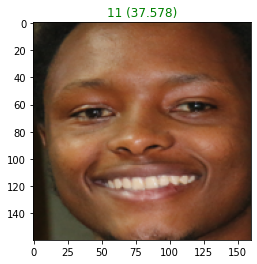

In [ ]:
plt.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title, color = 'green')
plt.show()


In [ ]:
def face_recognize(image):
    faces = extract_face(image, image_pixels=image)
    X = np.asarray(faces)
    ## Get the Face Embeddings for the extracted face pixels and store as numpy array
    embedding = get_embedding(model, X)
    X = []
    X.append(embedding)
    X = np.asarray(X)
    ## Predict label for the face by using the pretrained models
    prediction = model2.predict(X)
    prob = model2.predict_proba(X)
    accuracy = prob[0,prediction] * 100
    predicted_label = out_encoder.inverse_transform([prediction])
    title = ('%s (%.3f)' % (predicted_label[0], accuracy))
    plt.imshow(faces)
    plt.title(title, color = 'green')
    
    return plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


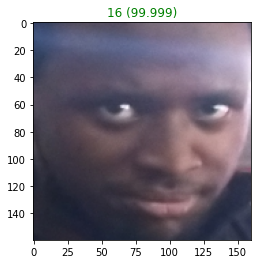

In [ ]:
img = ('/content/gdrive/MyDrive/Portfolio/Barbra/Snapchat-482178010.jpg')
face_recognize(img)


In [ ]:
import cv2 as cv

In [ ]:
cap = cv.VideoCapture(0)


In [ ]:
while True:
  ret, frame = cap.read()
  frame = cv.resize(frame, None, fx= 0.5, fy = 0.5, interpolation = cv.INTER_AREA)
  face_recognize(frame)
  